In [1]:
!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -vxf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

--2022-05-06 21:52:43--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  47.9MB/s    in 3.8s    

2022-05-06 21:52:47 (43.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [2]:
!pip install torchviz

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=93c83db1de63403eea0b3f915caf48c446385586548775697e2ae8c973dc01ba
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
import torchvision.models as models
import albumentations
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm import tqdm_notebook as tqdm
import os
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import gc

from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from torchviz import make_dot


device = torch.device('cuda')

### Utility functions:

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo,encoding='latin1')
    return dict


def scorer(models,x_test,y_true):
    for model in models:
        y_pred = model.predict(x_test)
        print(accuracy_score(y_true, y_pred))
        

from prettytable import PrettyTable

def count_parameters(model):
    #reference and credits : https://stackoverflow.com/a/62508086/9017542
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
        


In [4]:
ROOT_PATH='./' 
batch1 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_1")
batch2 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_2")
batch3 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_3")
batch4 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_4")
batch5 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_5")
test_batch = unpickle(ROOT_PATH+"cifar-10-batches-py/test_batch")

### Visualising Images

In [5]:
class_mapping = {0: 'airplane',
1: 'automobile',
2: 'bird',
3: 'cat',
4: 'deer',
5: 'dog',
6: 'frog' ,
7: 'horse',
8: 'ship',
9: 'truck'}

def visualize(batch):
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range(2):
        f, axarr = plt.subplots(1,5)
        for p in range(5):
            idx = np.random.randint(0, len(batch['data']))
            img = batch['data'][idx]
            label = batch['labels'][idx]
            name = batch['filenames'][idx]
            name = name.split('_')[0]
            axarr[p].imshow(np.fliplr(np.rot90(np.transpose(img.flatten().reshape(3,32,32)), k=-1)))
            axarr[p].set_title(class_mapping[label]+' ('+str(label)+')')
        

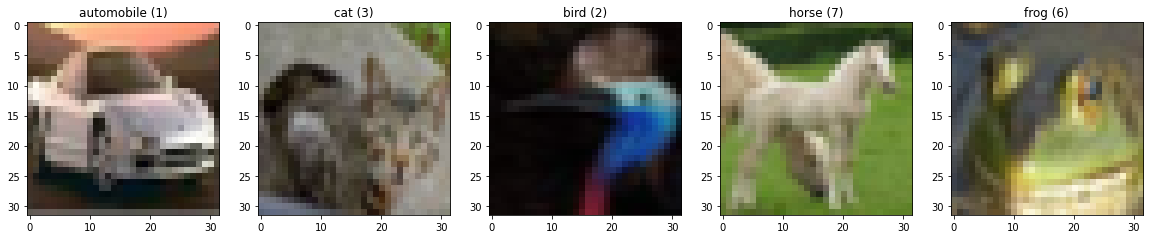

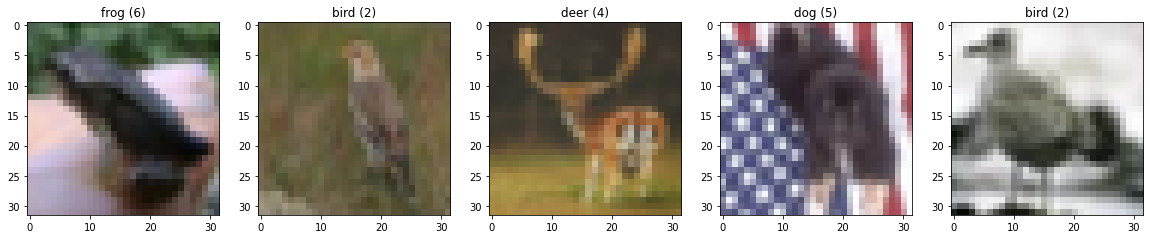

In [6]:
visualize(batch1)

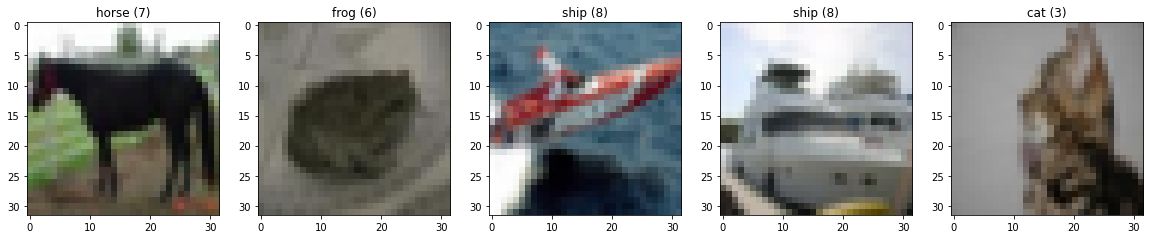

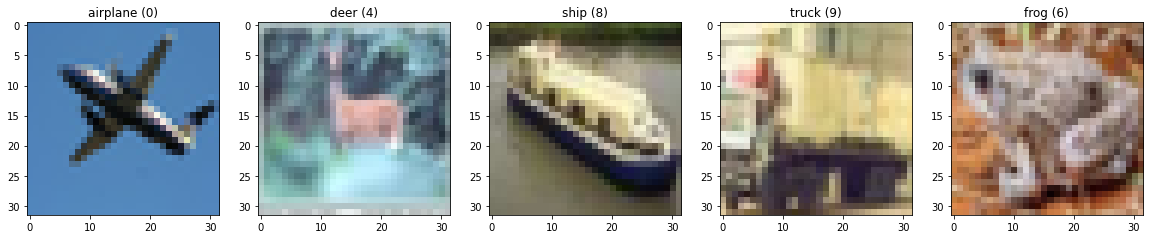

In [7]:
visualize(batch2)

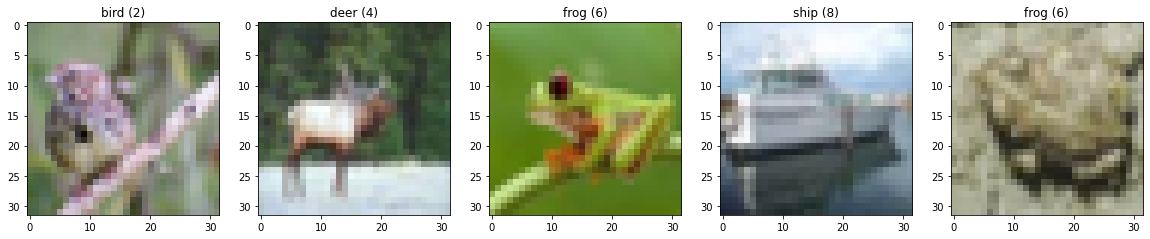

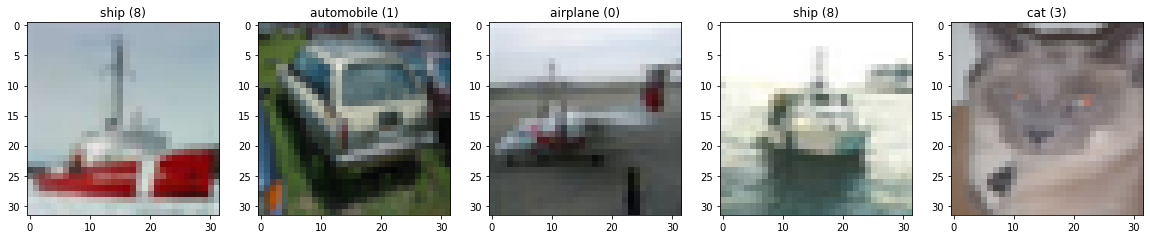

In [8]:
visualize(batch3)

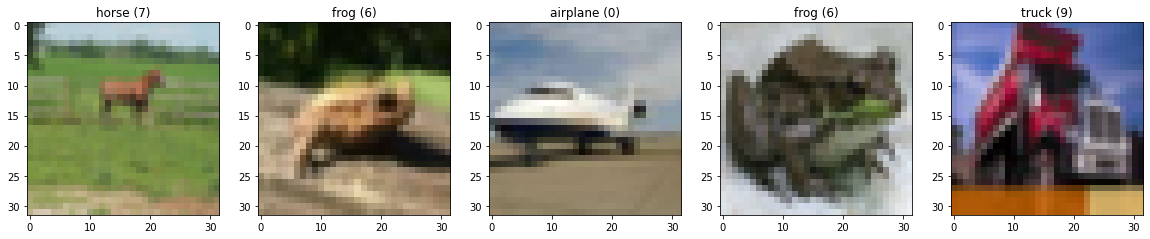

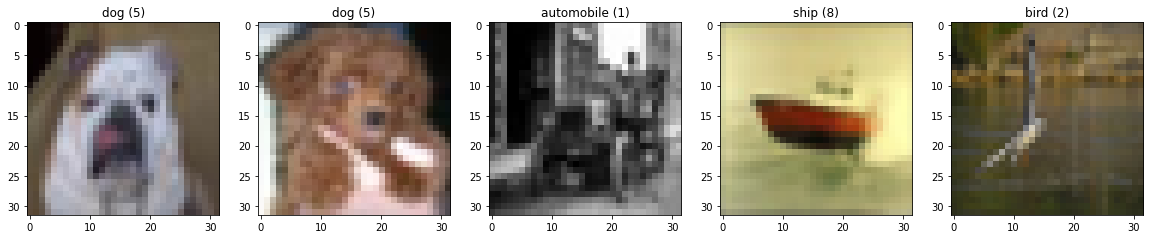

In [9]:
visualize(batch4)

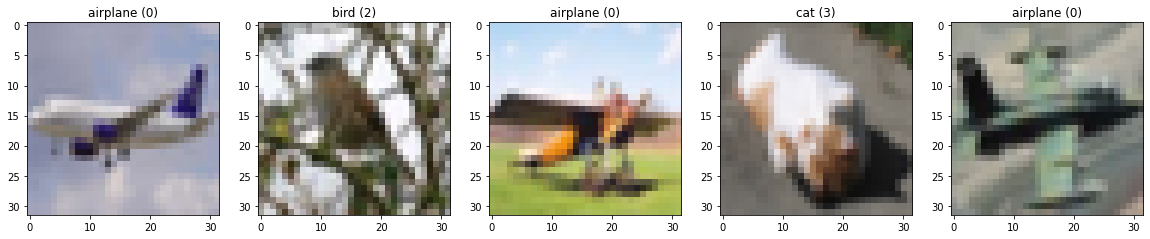

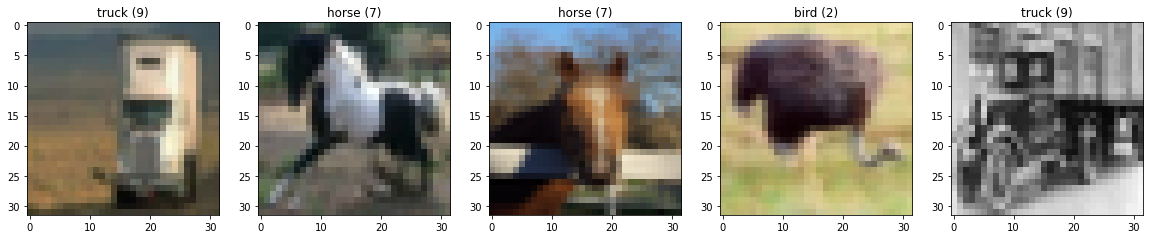

In [10]:
visualize(batch5)

# Numpy DataSet

In [11]:
def load_data0(btch):
    labels = btch['labels']
    imgs = btch['data'].reshape((-1, 32, 32, 3))
    
    res = []
    for ii in range(imgs.shape[0]):
        img = imgs[ii].copy()
        img = np.fliplr(np.rot90(np.transpose(img.flatten().reshape(3,32,32)), k=-1))
        res.append(img.flatten())
    imgs = np.stack(res)
    return labels, imgs


def load_data():
    x_train_l = []
    y_train_l = []
    for ibatch in [batch1, batch2, batch3, batch4, batch5]:
        labels, imgs = load_data0(ibatch)
        x_train_l.append(imgs)
        y_train_l.extend(labels)
    x_train = np.vstack(x_train_l)
    y_train = np.vstack(y_train_l)
    
    x_test_l = []
    y_test_l = []
    labels, imgs = load_data0(test_batch)
    x_test_l.append(imgs)
    y_test_l.extend(labels)
    x_test = np.vstack(x_test_l)
    y_test = np.vstack(y_test_l)
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 3072)
50000 train samples
10000 test samples


In [12]:
y_train = y_train.ravel()
y_test = y_test.ravel()

# Building Logistic Regression, Decision Trees, Random Forests. 

In [13]:
print('Building Logistic Regression')

lg = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 250, n_jobs = -1, random_state=0))
lg = lg.fit(x_train, y_train)
gc.collect()


print('Building Decision Trees')
dt = make_pipeline(StandardScaler(),DecisionTreeClassifier(random_state=42))
dt = dt.fit(x_train,y_train)


print('Building Random Forests')
rf = make_pipeline(StandardScaler(),RandomForestClassifier(max_depth=2, random_state=0))
rf = rf.fit(x_train,y_train)


scorer([lg,dt,rf],x_test,y_test)

Building Logistic Regression
Building Decision Trees
Building Random Forests
0.3818
0.2655
0.2662


In [14]:
gc.collect()

69

## Neural Networks


In [15]:
criterion = nn.CrossEntropyLoss()

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu = nn.ReLU(inplace=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x1 = self.relu(x)
        x = x+x1 #resnet like arch
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
class Vanilla_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
class resnet_cifar10(nn.Module):
    def __init__(self, out_dim):
        super(resnet_cifar10, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.myfc = nn.Linear(self.model.fc.in_features, out_dim)
        self.model.fc = nn.Identity()

    def extract(self, x):
        return self.model(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [19]:
def train_epoch(loader, optimizer):
    total = 0
    correct = 0
    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        _,pred = torch.max(logits,1)
        
        # Accuaracy code
        total += target.size(0)
        correct += (pred == target).sum().item()
        acc = 100 * (correct / total)
        
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        #smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, Accuracy: %.5f' % (loss_np, acc))
    return train_loss,acc


def val_epoch(loader, get_output=False):
    total = 0
    correct = 0
    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)
            
            loss = criterion(logits, target)
            #print(logits)
            _, pred = torch.max(logits, 1)
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target)
            total += target.size(0)
            correct += (pred == target).sum().item()
            
            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    
    #print(correct,total)
    acc = 100 * (correct / total)
        

    if get_output:
        return LOGITS
    else:
        return val_loss, acc

In [20]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [21]:
batch_size = 128
num_workers = 2
n_epochs = 10


train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
    
valid_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [22]:
def run(model,mtype,tl,vl):


    #dataset_train = CIFARDataset(data , transform=transform)
    #dataset_valid = CIFARDataset(test , transform=transform)
  

    #model = Net()
    model = model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9, weight_decay=5e-4)
    #optim.Adam(model.parameters(), lr=0.01)
    

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    #print(len(dataset_train), len(dataset_valid))
    
    train_list = []
    train_acc_list = []
    val_list = []
    val_acc_list = []
    
    acc_max = 0
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)

        train_loss,t_acc = train_epoch(tl, optimizer)
        train_list.append(np.mean(train_loss))
        train_acc_list.append(t_acc)
        val_loss, acc = val_epoch(vl)
        val_list.append(np.mean(val_loss))
        val_acc_list.append(acc)
        scheduler.step()
        
        #print)

        content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}'
        print(content)
        with open(f'log_basic_cnn.txt', 'a') as appender:
            appender.write(content + '\n')

        if acc > acc_max:
            print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(acc_max, acc))
            torch.save(model.state_dict(), f'model.pth')
            acc_max = acc
    
    
    x_ticks = [1,2,3,4,5,6,7,8,9,10]
    x_labels = [1,2,3,4,5,6,7,8,9,10] 
    
    plt.figure(figsize=(10, 8))
    plt.plot(train_list)
    plt.plot(val_list)
    plt.title(f'Training Loss vs Validation Loss for {mtype}')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.xticks(ticks=x_ticks, labels=x_labels)
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    
    plt.figure(figsize=(10, 8))
    plt.plot(train_acc_list)
    plt.plot(val_acc_list)
    plt.title(f'Training Accuracy vs Validation Accuracy for {mtype}')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.xticks(ticks=x_ticks, labels=x_labels)
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    
    torch.save(model.state_dict(), os.path.join(f'basic_cnn_final.pth'))

Fri May  6 22:02:50 2022 Epoch: 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/391 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:03:07 2022 Epoch 1, lr: 0.0099994, train loss: 1.89070, val loss: 1.64231, acc: 40.43000
score2 (0.000000 --> 40.430000).  Saving model ...
Fri May  6 22:03:07 2022 Epoch: 2


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:03:20 2022 Epoch 2, lr: 0.0099975, train loss: 1.48201, val loss: 1.38619, acc: 49.56000
score2 (40.430000 --> 49.560000).  Saving model ...
Fri May  6 22:03:20 2022 Epoch: 3


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:03:33 2022 Epoch 3, lr: 0.0099944, train loss: 1.33795, val loss: 1.31931, acc: 52.08000
score2 (49.560000 --> 52.080000).  Saving model ...
Fri May  6 22:03:33 2022 Epoch: 4


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:03:46 2022 Epoch 4, lr: 0.0099901, train loss: 1.23499, val loss: 1.21997, acc: 56.84000
score2 (52.080000 --> 56.840000).  Saving model ...
Fri May  6 22:03:46 2022 Epoch: 5


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:03:58 2022 Epoch 5, lr: 0.0099846, train loss: 1.14856, val loss: 1.16471, acc: 58.89000
score2 (56.840000 --> 58.890000).  Saving model ...
Fri May  6 22:03:58 2022 Epoch: 6


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:04:10 2022 Epoch 6, lr: 0.0099778, train loss: 1.09068, val loss: 1.14494, acc: 59.92000
score2 (58.890000 --> 59.920000).  Saving model ...
Fri May  6 22:04:10 2022 Epoch: 7


  0%|          | 0/391 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:04:23 2022 Epoch 7, lr: 0.0099698, train loss: 1.03193, val loss: 1.08563, acc: 62.02000
score2 (59.920000 --> 62.020000).  Saving model ...
Fri May  6 22:04:23 2022 Epoch: 8


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:04:35 2022 Epoch 8, lr: 0.0099606, train loss: 0.98304, val loss: 1.07774, acc: 62.81000
score2 (62.020000 --> 62.810000).  Saving model ...
Fri May  6 22:04:35 2022 Epoch: 9


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:04:47 2022 Epoch 9, lr: 0.0099501, train loss: 0.93714, val loss: 1.05572, acc: 63.89000
score2 (62.810000 --> 63.890000).  Saving model ...
Fri May  6 22:04:47 2022 Epoch: 10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:05:00 2022 Epoch 10, lr: 0.0099384, train loss: 0.89950, val loss: 1.05715, acc: 64.18000
score2 (63.890000 --> 64.180000).  Saving model ...


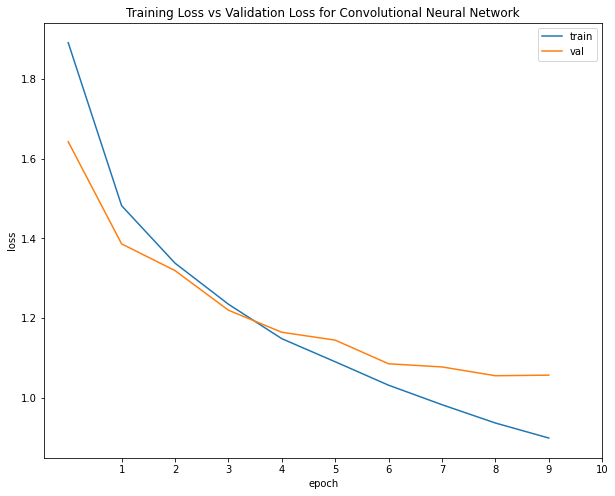

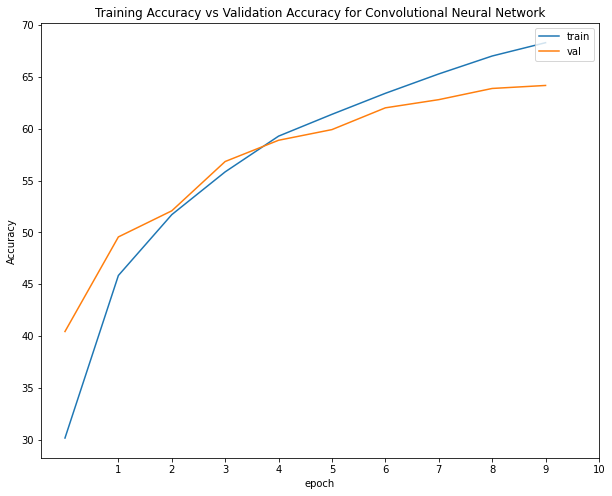

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    450     |
|  conv1.bias  |     6      |
| conv2.weight |    2400    |
|  conv2.bias  |     16     |
|  fc1.weight  |   48000    |
|   fc1.bias   |    120     |
|  fc2.weight  |   10080    |
|   fc2.bias   |     84     |
|  fc3.weight  |    840     |
|   fc3.bias   |     10     |
+--------------+------------+
Total Trainable Params: 62006


62006

In [23]:
model = Net()
run(model,'Convolutional Neural Network',train_loader,valid_loader)
batch = next(iter(train_loader))
yhat = model(batch[0].to(device))
make_dot(yhat, params=dict(list(model.named_parameters()))).render("cnn")
count_parameters(model)

Fri May  6 22:05:01 2022 Epoch: 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/391 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:05:13 2022 Epoch 1, lr: 0.0099994, train loss: 1.76671, val loss: 1.53489, acc: 46.04000
score2 (0.000000 --> 46.040000).  Saving model ...
Fri May  6 22:05:13 2022 Epoch: 2


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:05:26 2022 Epoch 2, lr: 0.0099975, train loss: 1.48289, val loss: 1.46835, acc: 48.00000
score2 (46.040000 --> 48.000000).  Saving model ...
Fri May  6 22:05:26 2022 Epoch: 3


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:05:38 2022 Epoch 3, lr: 0.0099944, train loss: 1.36158, val loss: 1.35509, acc: 52.28000
score2 (48.000000 --> 52.280000).  Saving model ...
Fri May  6 22:05:38 2022 Epoch: 4


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:05:49 2022 Epoch 4, lr: 0.0099901, train loss: 1.27260, val loss: 1.35220, acc: 51.80000
Fri May  6 22:05:49 2022 Epoch: 5


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:06:02 2022 Epoch 5, lr: 0.0099846, train loss: 1.20295, val loss: 1.33433, acc: 52.88000
score2 (52.280000 --> 52.880000).  Saving model ...
Fri May  6 22:06:02 2022 Epoch: 6


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:06:14 2022 Epoch 6, lr: 0.0099778, train loss: 1.13463, val loss: 1.32994, acc: 53.46000
score2 (52.880000 --> 53.460000).  Saving model ...
Fri May  6 22:06:14 2022 Epoch: 7


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:06:26 2022 Epoch 7, lr: 0.0099698, train loss: 1.07508, val loss: 1.34684, acc: 53.38000
Fri May  6 22:06:26 2022 Epoch: 8


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:06:38 2022 Epoch 8, lr: 0.0099606, train loss: 1.00941, val loss: 1.31406, acc: 54.74000
score2 (53.460000 --> 54.740000).  Saving model ...
Fri May  6 22:06:38 2022 Epoch: 9


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:06:50 2022 Epoch 9, lr: 0.0099501, train loss: 0.95396, val loss: 1.32911, acc: 54.73000
Fri May  6 22:06:50 2022 Epoch: 10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:07:02 2022 Epoch 10, lr: 0.0099384, train loss: 0.89750, val loss: 1.34595, acc: 54.45000


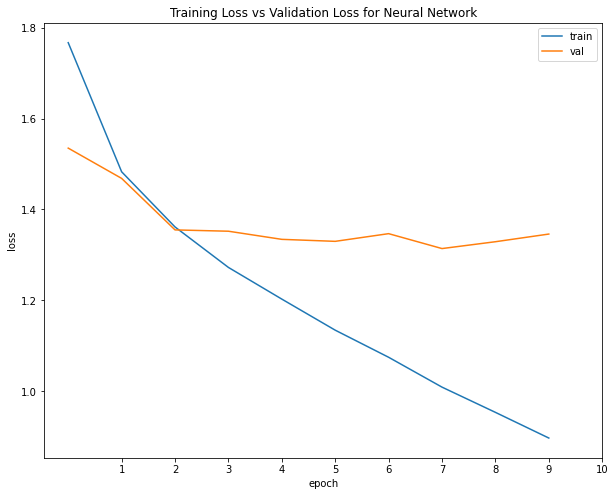

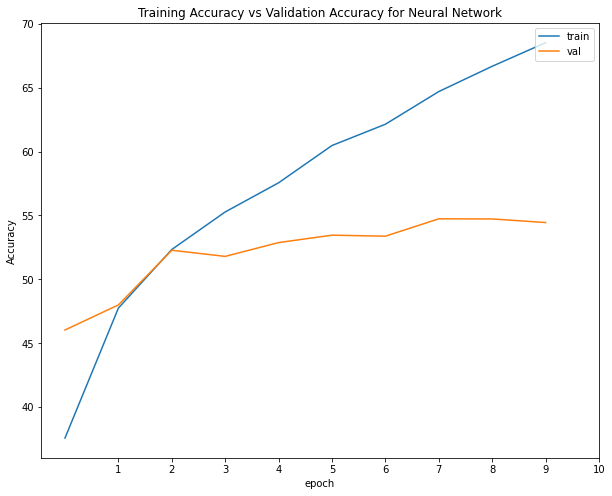

+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |  3145728   |
|  fc1.bias  |    1024    |
| fc2.weight |   262144   |
|  fc2.bias  |    256     |
| fc3.weight |    2560    |
|  fc3.bias  |     10     |
+------------+------------+
Total Trainable Params: 3411722


3411722

In [24]:
model = Vanilla_Net()
run(model,'Neural Network',train_loader,valid_loader)
batch = next(iter(train_loader))
yhat = model(batch[0].to(device))
make_dot(yhat, params=dict(list(model.named_parameters()))).render("nn")
count_parameters(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Fri May  6 22:07:10 2022 Epoch: 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/391 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:07:28 2022 Epoch 1, lr: 0.0099994, train loss: 0.90186, val loss: 0.67210, acc: 77.27000
score2 (0.000000 --> 77.270000).  Saving model ...
Fri May  6 22:07:28 2022 Epoch: 2


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:07:45 2022 Epoch 2, lr: 0.0099975, train loss: 0.53770, val loss: 0.67440, acc: 77.93000
score2 (77.270000 --> 77.930000).  Saving model ...
Fri May  6 22:07:45 2022 Epoch: 3


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:08:03 2022 Epoch 3, lr: 0.0099944, train loss: 0.42388, val loss: 0.59340, acc: 80.16000
score2 (77.930000 --> 80.160000).  Saving model ...
Fri May  6 22:08:03 2022 Epoch: 4


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:08:20 2022 Epoch 4, lr: 0.0099901, train loss: 0.31421, val loss: 0.59321, acc: 81.54000
score2 (80.160000 --> 81.540000).  Saving model ...
Fri May  6 22:08:20 2022 Epoch: 5


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:08:37 2022 Epoch 5, lr: 0.0099846, train loss: 0.25525, val loss: 0.58915, acc: 81.08000
Fri May  6 22:08:37 2022 Epoch: 6


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:08:54 2022 Epoch 6, lr: 0.0099778, train loss: 0.21546, val loss: 0.66928, acc: 80.45000
Fri May  6 22:08:54 2022 Epoch: 7


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:09:11 2022 Epoch 7, lr: 0.0099698, train loss: 0.18735, val loss: 0.67115, acc: 80.90000
Fri May  6 22:09:11 2022 Epoch: 8


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:09:29 2022 Epoch 8, lr: 0.0099606, train loss: 0.14903, val loss: 0.69431, acc: 81.45000
Fri May  6 22:09:29 2022 Epoch: 9


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:09:45 2022 Epoch 9, lr: 0.0099501, train loss: 0.13813, val loss: 0.66512, acc: 81.98000
score2 (81.540000 --> 81.980000).  Saving model ...
Fri May  6 22:09:46 2022 Epoch: 10


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Fri May  6 22:10:03 2022 Epoch 10, lr: 0.0099384, train loss: 0.11542, val loss: 0.74482, acc: 80.80000


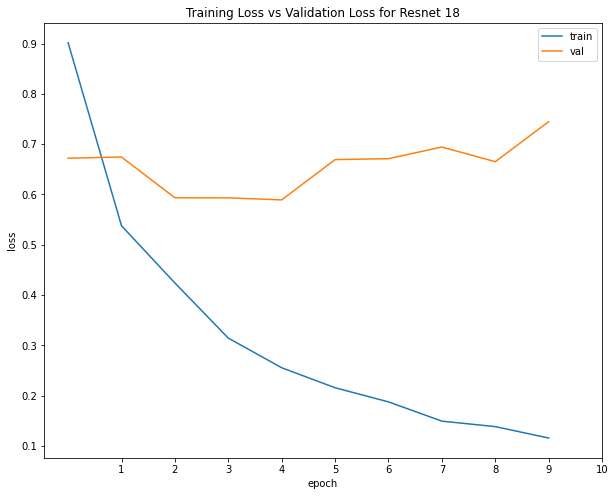

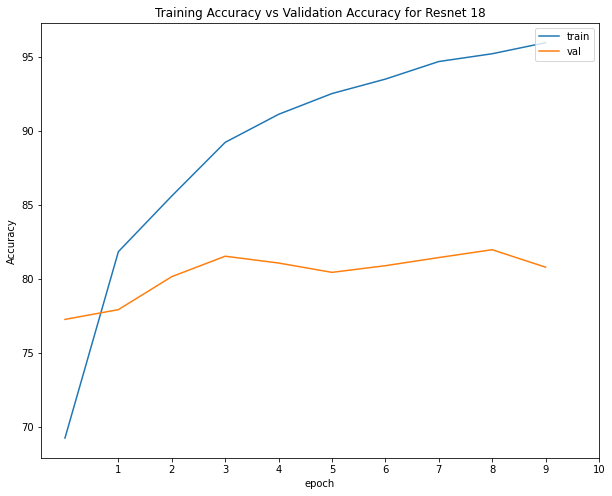

+------------------------------------+------------+
|              Modules               | Parameters |
+------------------------------------+------------+
|         model.conv1.weight         |    9408    |
|          model.bn1.weight          |     64     |
|           model.bn1.bias           |     64     |
|    model.layer1.0.conv1.weight     |   36864    |
|     model.layer1.0.bn1.weight      |     64     |
|      model.layer1.0.bn1.bias       |     64     |
|    model.layer1.0.conv2.weight     |   36864    |
|     model.layer1.0.bn2.weight      |     64     |
|      model.layer1.0.bn2.bias       |     64     |
|    model.layer1.1.conv1.weight     |   36864    |
|     model.layer1.1.bn1.weight      |     64     |
|      model.layer1.1.bn1.bias       |     64     |
|    model.layer1.1.conv2.weight     |   36864    |
|     model.layer1.1.bn2.weight      |     64     |
|      model.layer1.1.bn2.bias       |     64     |
|    model.layer2.0.conv1.weight     |   73728    |
|     model.

11181642

In [25]:
model = resnet_cifar10(out_dim = 10)
run(model,'Resnet 18',train_loader,valid_loader)
batch = next(iter(train_loader))
yhat = model(batch[0].to(device))
make_dot(yhat, params=dict(list(model.named_parameters()))).render("resnet")
count_parameters(model) 